# Cas Kaggle - Predicció obessitat
https://www.kaggle.com/datasets/aravindpcoder/obesity-or-cvd-risk-classifyregressorcluster/data

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
import time

from sklearn.linear_model import LogisticRegression, LinearRegression
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import  DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer



### Descripció de les variables
- Frequent consumption of high caloric food (FAVC)
- Frequency of consumption of vegetables (FCVC) 
- Number of main meals (NCP)
- Consumption of food between meals (CAEC)
- Consumption of water daily (CH20)
- Consumption of alcohol (CALC). 
- Calories consumption monitoring (SCC)
- Physical activity frequency (FAF)
- Time using technology devices (TUE)
- Transportation used (MTRANS)

## Dividir training i test

In [103]:
# Carregar el CSV en un DataFrame
df_full = pd.read_csv("ObesityDataSet.csv", encoding="utf-8")

# Mostrar les primeres files
df_full



,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.000000,1.620000,64.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation,Normal_Weight
1,Female,21.000000,1.520000,56.000000,yes,no,3.0,3.0,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.000000,1.800000,77.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation,Normal_Weight
3,Male,27.000000,1.800000,87.000000,no,no,3.0,3.0,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking,Overweight_Level_I
4,Male,22.000000,1.780000,89.800000,no,no,2.0,1.0,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


Dividim el dataset per 70-15-15 (train,validation,test)

In [104]:
# Dividir les dades en train i test
X = df_full[[col for col in df_full.columns if col != 'NObeyesdad']]
y = df_full['NObeyesdad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1794, 16), (317, 16), (1794,), (317,))

## Explortory data analysis

In [105]:
# Crear un DataFrame que utilitzarem per entrenar i validar els models
df_split = pd.concat([X_train, y_train], axis=1)
# Crear un DataFrame que utilitzarem al final per provar el model triat
df_tester = pd.concat([X_test, y_test], axis=1)

# mostrem el conjunt d'entrenament i validació 
df_split


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
1994,Female,21.282238,1.748951,133.662583,yes,yes,3.000000,3.000000,Sometimes,no,2.247979,no,1.609938,0.849236,Sometimes,Public_Transportation,Obesity_Type_III
17,Female,29.000000,1.530000,78.000000,no,yes,2.000000,1.000000,Sometimes,no,2.000000,no,0.000000,0.000000,no,Automobile,Obesity_Type_I
206,Male,19.000000,1.750000,100.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,2.000000,0.000000,no,Public_Transportation,Obesity_Type_I
1944,Female,21.051982,1.729719,131.877558,yes,yes,3.000000,3.000000,Sometimes,no,1.422483,no,1.708971,0.673009,Sometimes,Public_Transportation,Obesity_Type_III
1198,Male,18.000000,1.750097,86.372141,yes,yes,2.907062,3.000000,Sometimes,no,2.740848,no,1.219827,0.037634,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1560,Male,25.300208,1.765258,114.330023,yes,yes,1.562804,3.000000,Sometimes,no,2.075493,no,1.553734,0.000436,Sometimes,Public_Transportation,Obesity_Type_II
162,Female,21.000000,1.630000,60.000000,yes,yes,3.000000,3.000000,Always,yes,2.000000,no,2.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
609,Male,19.979810,1.753360,54.997374,yes,yes,2.000000,3.494849,Sometimes,no,2.976672,no,1.949070,2.000000,no,Public_Transportation,Insufficient_Weight
1718,Male,25.879411,1.765464,114.144378,yes,yes,1.626369,3.000000,Sometimes,no,2.109697,no,1.352973,0.076693,Sometimes,Public_Transportation,Obesity_Type_II


In [106]:
print(df_split.describe())

               Age       Height       Weight         FCVC          NCP  \
count  1794.000000  1794.000000  1794.000000  1794.000000  1794.000000   
mean     24.283944     1.702314    86.580621     2.426377     2.682923   
std       6.339740     0.093515    25.997022     0.529187     0.777583   
min      14.000000     1.456346    39.000000     1.000000     1.000000   
25%      19.899719     1.629550    65.934516     2.000000     2.656871   
50%      22.762612     1.701609    83.231077     2.398408     3.000000   
75%      26.000000     1.770000   107.087496     3.000000     3.000000   
max      61.000000     1.980000   160.639405     3.000000     4.000000   

              CH2O          FAF          TUE  
count  1794.000000  1794.000000  1794.000000  
mean      2.016808     1.016984     0.652431  
std       0.612781     0.845354     0.601616  
min       1.000000     0.000000     0.000000  
25%       1.607680     0.131685     0.000000  
50%       2.000000     1.000000     0.619850  
75% 

In [107]:
print("Número d'atributs del dataset:", len(df_split.keys()))
print("Número de files en el train (mostres): ",df_split.shape[0])

Número d'atributs del dataset: 17
Número de files en el train (mostres):  1794


In [108]:
# Mirem valors NaN per atribut
nan_counts = df_split.isna().sum()
var_type = df_split.dtypes
# Mostrem una taula amb els valors NaN i el tipus de variable
print("Valors NaN per atribut i tipus de variable:")
print(pd.DataFrame({"NaN Count": nan_counts, "Variable Type": var_type}))

Valors NaN per atribut i tipus de variable:
                                NaN Count Variable Type
Gender                                  0        object
Age                                     0       float64
Height                                  0       float64
Weight                                  0       float64
family_history_with_overweight          0        object
FAVC                                    0        object
FCVC                                    0       float64
NCP                                     0       float64
CAEC                                    0        object
SMOKE                                   0        object
CH2O                                    0       float64
SCC                                     0        object
FAF                                     0       float64
TUE                                     0       float64
CALC                                    0        object
MTRANS                                  0        object
NObe

No hi ha NANS.

Variables catagòriques:
- Gènere (dona/home) --> binaria
- Historial familiar (si/no) --> binaria
- consum freq d'aliments en calories FAVC (si/no) --> binaria
- Freq de menjar amb carn CAEC (sempre,freqüent, a vegades,no) --> ordinal
- Fumar(sí/no) --> binaria
- Monitorització consum de calories SCC (sí/no) --> binaria
- Consum d'alcohol CALC (sempre,freqüent, a vegades,no) --> ordinal
- Transport (automobil, moto, trans public, caminar, bici)
- Tipus d'obestitat (obesitat tipus 1/2, sobrepres 1/2, pes normal, pes insuficient) --> ordinal

Variables númeriques:
- Edat
- Alçada
- Pes
- Frequencia del consum de verdures (FCVC)
- Número de carns NCP
- Consum d'aigua CH20
- Freq d'activitat física FAF
- Temps d'ús disp tecno TUE


C:\Users\annit\AppData\Local\Temp\ipykernel_46912\1439807946.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
C:\Users\annit\AppData\Local\Temp\ipykernel_46912\1439807946.py:13: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.countplot(
C:\Users\annit\AppData\Local\Temp\ipykernel_46912\1439807946.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
C:\Users\annit\AppData\Local\Temp\ipykernel_46912\1439807946.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
C:\Users\

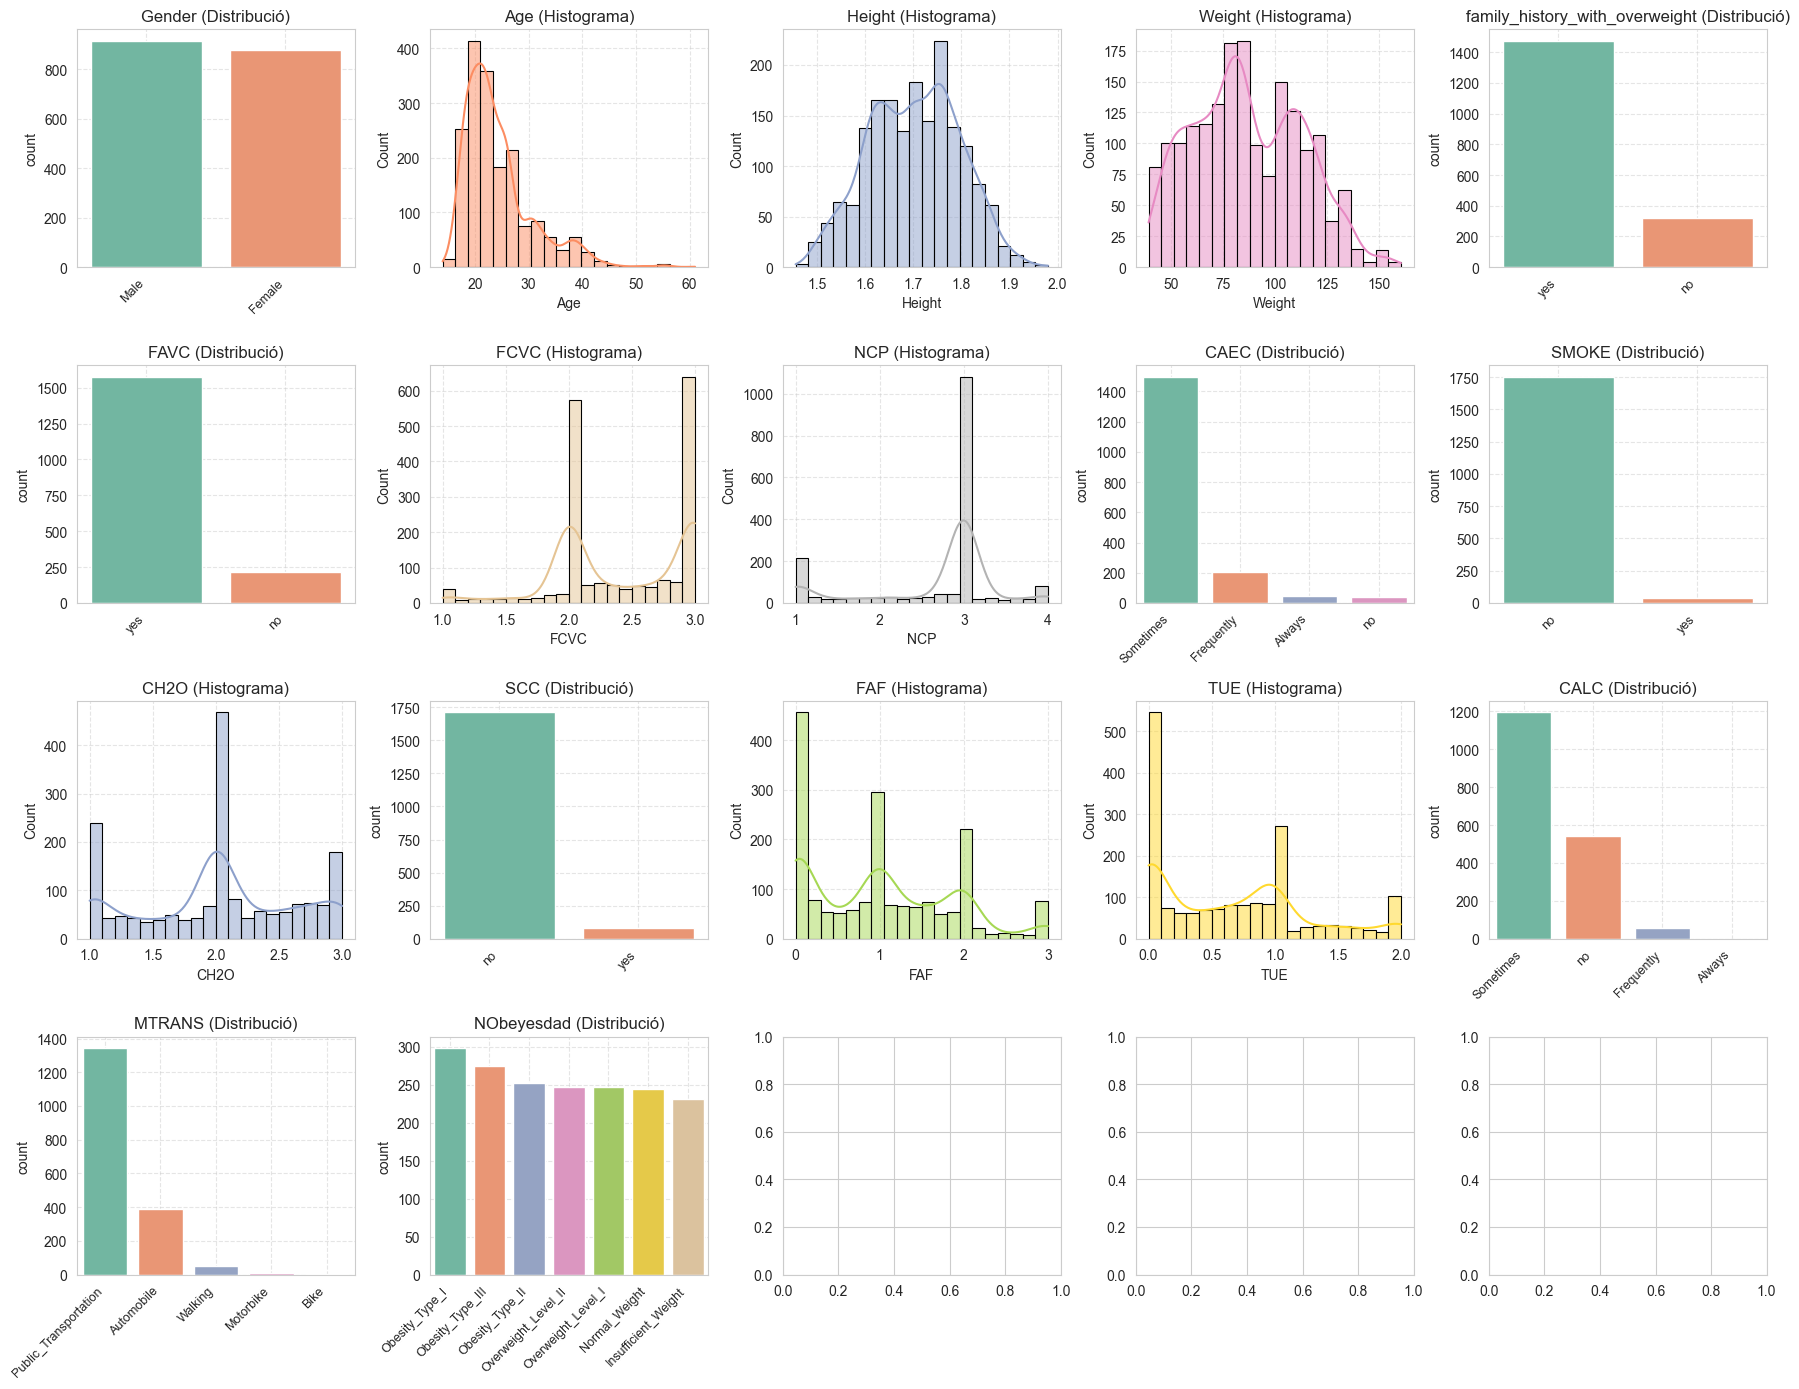

In [109]:
cols = df_split.columns.tolist()

sns.set_style("whitegrid")
palette = sns.color_palette("Set2")

fig, axes = plt.subplots(4, 5, figsize=(18, 14))
axes = axes.flatten()

for i, col in enumerate(cols[:17]): 
    ax = axes[i]
    
    if (not pd.api.types.is_numeric_dtype(df_split[col])) or (df_split[col].nunique() <= 6):
        sns.countplot(
            x=df_split[col], 
            ax=ax, 
            order=df_split[col].value_counts().index, 
            palette=palette
        )
        ax.set_title(f'{col} (Distribució)')
        ax.set_xlabel('')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)

    else:
        sns.histplot(
            data=df_split, 
            x=col, 
            bins=20, 
            kde=True, # Afegim suavització (KDE)
            color=palette[i % len(palette)], # Assigna un color de la paleta
            edgecolor='black',
            ax=ax
        )
        ax.set_title(f'{col} (Histograma)', fontsize=12)
        ax.set_xlabel(col, fontsize=10)

    
    
    ax.grid(True, linestyle='--', alpha=0.5)

for j in range(i + 1, 17):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

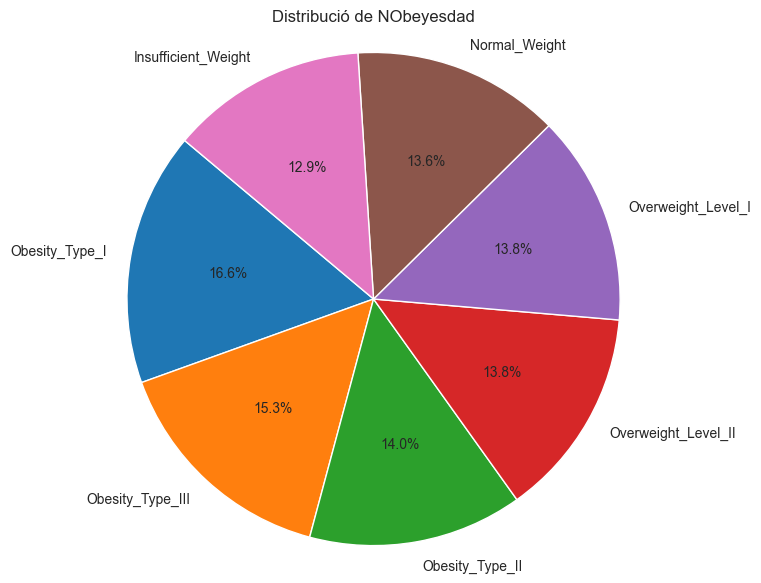

In [110]:
import matplotlib.pyplot as plt

counts = df_split['NObeyesdad'].value_counts()

plt.figure(figsize=(7, 7))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribució de NObeyesdad')
plt.axis('equal')
plt.show()

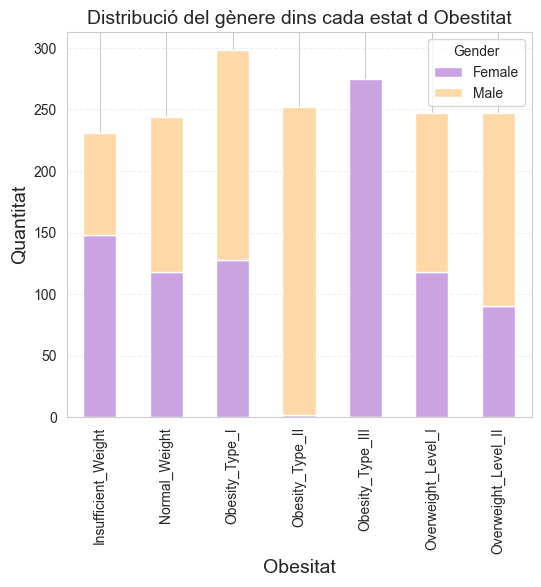

In [111]:
ct_rev = pd.crosstab(df_split["NObeyesdad"], df_split['Gender']) 

ct_rev.plot(kind='bar', stacked=True, 
            color=['#CBA3E3', '#FFD8A8'], 
            figsize=(6,5))

plt.title('Distribució del gènere dins cada estat d Obestitat', fontsize=14)
plt.xlabel('Obesitat', fontsize=14)
plt.ylabel('Quantitat', fontsize=14)
plt.grid(alpha=0.3, axis='y', linestyle='--')
plt.show()

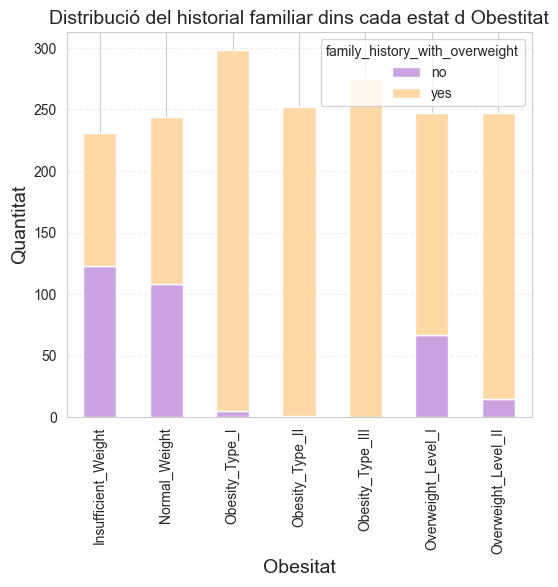

In [112]:
ct_rev = pd.crosstab(df_split["NObeyesdad"], df_split["family_history_with_overweight"]) 

ct_rev.plot(kind='bar', stacked=True, 
            color=['#CBA3E3', '#FFD8A8'], 
            figsize=(6,5))

plt.title('Distribució del historial familiar dins cada estat d Obestitat', fontsize=14)
plt.xlabel('Obesitat', fontsize=14)
plt.ylabel('Quantitat', fontsize=14)
plt.grid(alpha=0.3, axis='y', linestyle='--')
plt.show()

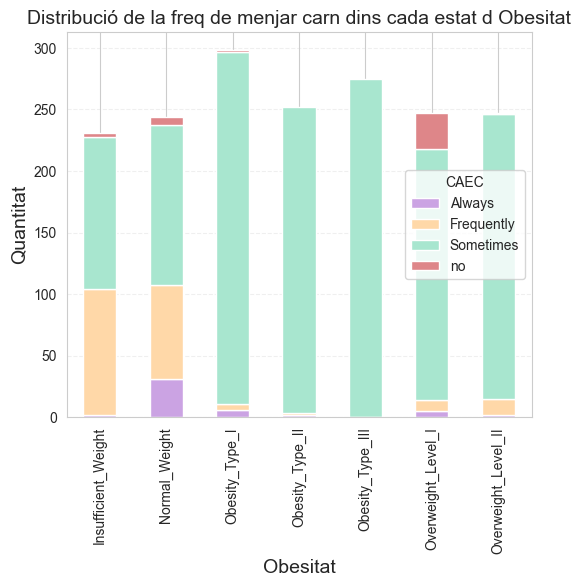

In [113]:
ct_rev = pd.crosstab(df_split["NObeyesdad"], df_split['CAEC'] ) 

ct_rev.plot(kind='bar', stacked=True, color=['#CBA3E3', '#FFD8A8', '#A8E6CF',"#DE8689"],
            figsize=(6,5))

plt.title('Distribució de la freq de menjar carn dins cada estat d Obesitat', fontsize=14)
plt.xlabel('Obesitat', fontsize=14)
plt.ylabel('Quantitat', fontsize=14)
plt.grid(alpha=0.3, axis='y', linestyle='--')
plt.show()

Comentem algo

Mirem si hi ha outliers

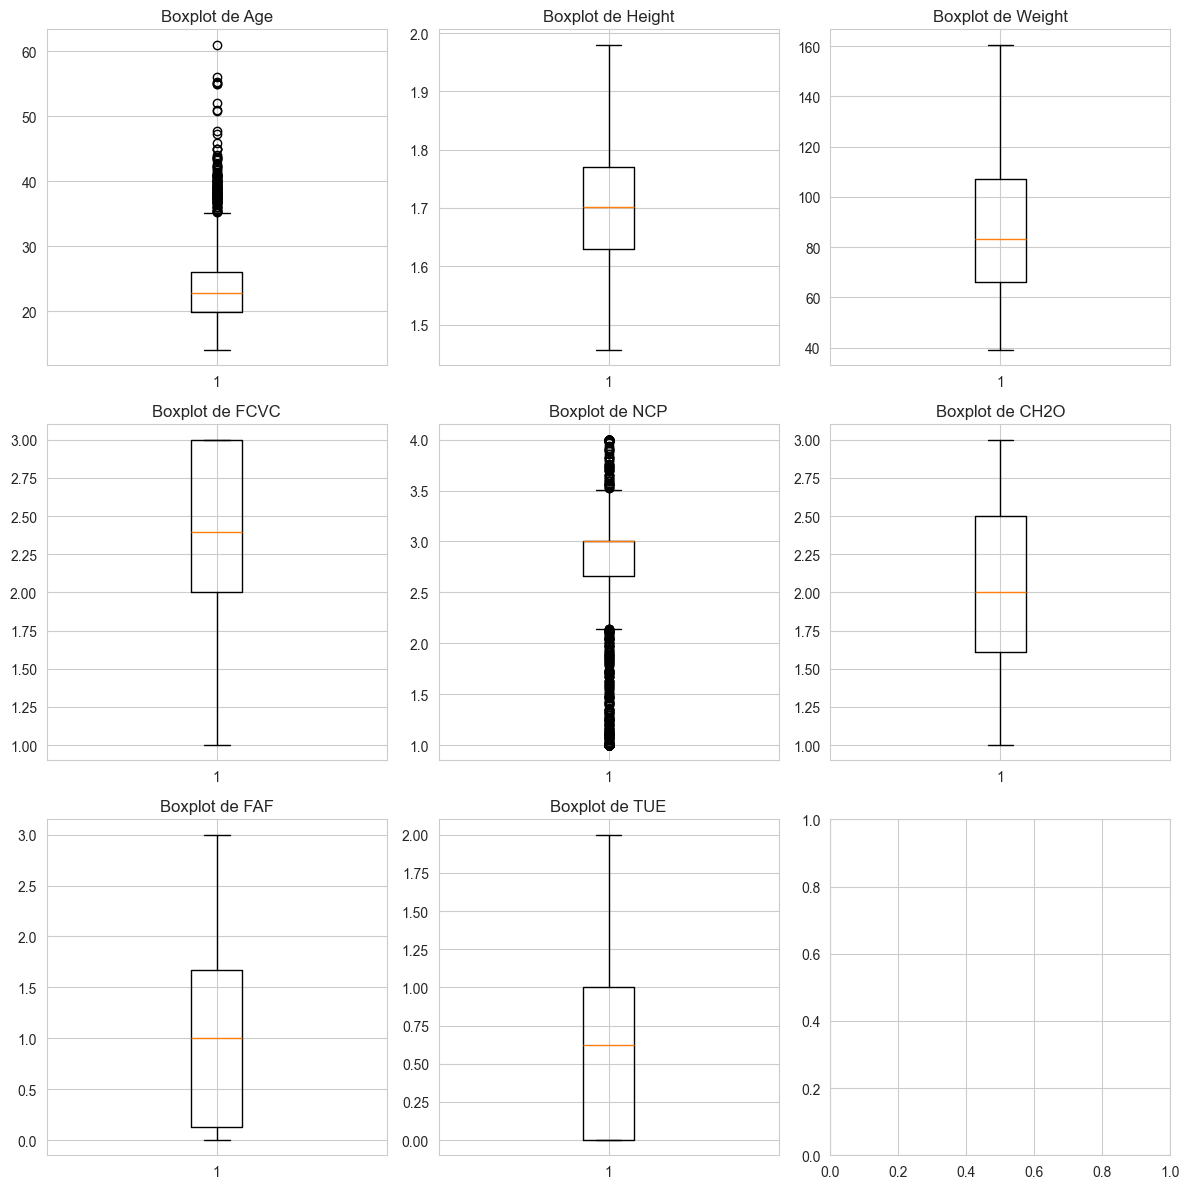

In [114]:
# Seleccionem només les variables numèriques
numeriques = df_split.select_dtypes(include=['float64', 'int64']).columns

# Definim la quadrícula 3x2
fig, axes = plt.subplots(3, 3, figsize=(12, 12))  # 3 files, 2 columnes
axes = axes.flatten()  # convertim a array 1D per iterar més fàcil

# Fem el boxplot per cada variable
for i, col in enumerate(numeriques[:8]):  # Només 6 variables per a 3x2
    axes[i].boxplot(df_split[col])
    axes[i].set_title(f"Boxplot de {col}")

plt.tight_layout()
plt.show()

No veiem cap boxplot amb outliers importants, la variable NPC està entre valors del 0 al 4 i age entre 14 i 61. Però al normalitzar utilitzarem el z-score.

In [115]:
df_split = pd.get_dummies(df_split, columns=['MTRANS'])
df_split.head()

bool_cols = df_split.select_dtypes(include='bool').columns
df_split[bool_cols] = df_split[bool_cols].astype(int)

In [116]:
df_split['Gender'] = df_split['Gender'].replace({'Male': 1, 'Female': 0})
df_split['family_history_with_overweight'] = df_split['family_history_with_overweight'].replace({'yes': 1, 'no': 0})
df_split['FAVC'] = df_split['FAVC'].replace({'yes': 1, 'no': 0})
df_split['SMOKE'] = df_split['SMOKE'].replace({'yes': 1, 'no': 0})
df_split['SCC'] = df_split['SCC'].replace({'yes': 1, 'no': 0})
df_split['CALC'] = df_split['CALC'].replace({'Always': 3,'Frequently': 2,'Sometimes': 1, 'no': 0})
df_split['CAEC'] = df_split['CAEC'].replace({'Always': 3,'Frequently': 2,'Sometimes': 1, 'no': 0})

C:\Users\annit\AppData\Local\Temp\ipykernel_46912\632722537.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_split['Gender'] = df_split['Gender'].replace({'Male': 1, 'Female': 0})
C:\Users\annit\AppData\Local\Temp\ipykernel_46912\632722537.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_split['family_history_with_overweight'] = df_split['family_history_with_overweight'].replace({'yes': 1, 'no': 0})
C:\Users\annit\AppData\Local\Temp\ipykernel_46912\632722537.py:3: FutureWarning: Downcasting behavior in `replace` is dep

In [117]:
df_split.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,SCC,FAF,TUE,CALC,NObeyesdad,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
1994,0,21.282238,1.748951,133.662583,1,1,3.000000,3.0,1,0,...,0,1.609938,0.849236,1,Obesity_Type_III,0,0,0,1,0
17,0,29.000000,1.530000,78.000000,0,1,2.000000,1.0,1,0,...,0,0.000000,0.000000,0,Obesity_Type_I,1,0,0,0,0
206,1,19.000000,1.750000,100.000000,1,1,2.000000,3.0,2,0,...,0,2.000000,0.000000,0,Obesity_Type_I,0,0,0,1,0
1944,0,21.051982,1.729719,131.877558,1,1,3.000000,3.0,1,0,...,0,1.708971,0.673009,1,Obesity_Type_III,0,0,0,1,0
1198,1,18.000000,1.750097,86.372141,1,1,2.907062,3.0,1,0,...,0,1.219827,0.037634,1,Overweight_Level_II,0,0,0,1,0


Regressió de la variable resposta

In [118]:
df_split['NObeyesdad'] = df_split['NObeyesdad'].replace({'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Overweight_Level_I': 2, 'Overweight_Level_II': 3, 'Obesity_Type_I': 4, 'Obesity_Type_II': 5, 'Obesity_Type_III': 6})

C:\Users\annit\AppData\Local\Temp\ipykernel_46912\2853249978.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_split['NObeyesdad'] = df_split['NObeyesdad'].replace({'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Overweight_Level_I': 2, 'Overweight_Level_II': 3, 'Obesity_Type_I': 4, 'Obesity_Type_II': 5, 'Obesity_Type_III': 6})


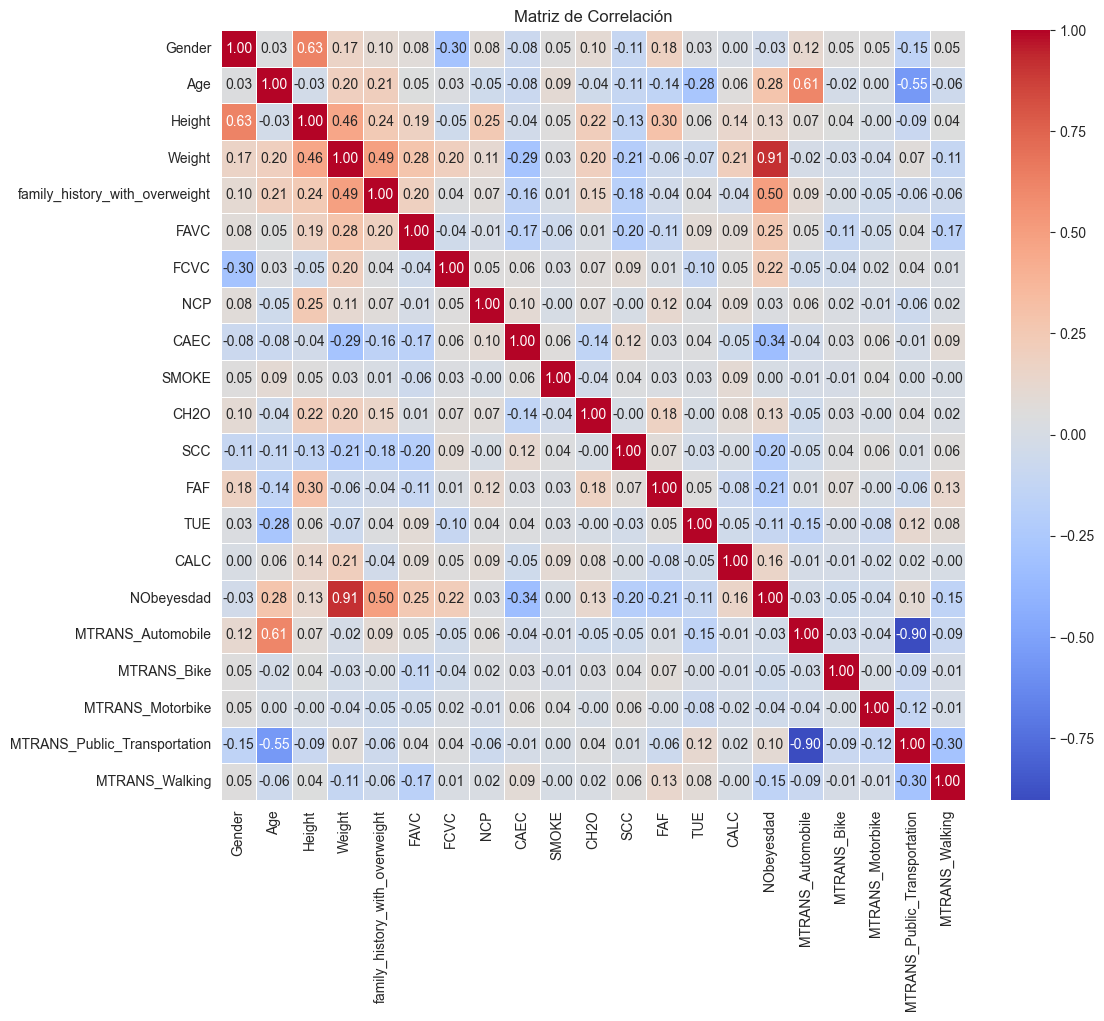

In [119]:
corr_matrix = df_split.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Matriz de Correlación')
plt.show()

Veiem que el pes té una correlació molt alta a la variable resposta. Cosa que té sentit ja que la classificació de NObeyesdad s'assigna de la segëunt manera segons el valor de BMI (body mass index):
- Underweight Less than 18.5
- Normal 18.5 to 24.9
- Overweight 25.0 to 29.9
- Obesity I 30.0 to 34.9
- Obesity II 35.0 to 39.9
- Obesity III Higher than 40

Per calcular el BMI: $ BMI = \frac{weight}{height^2}$. Veiem a la taula de correlacions que la variable Weight té molt de pes a la classificació del tipus d'obessitat, cosa que és obvia. Com el que volem és estudiar el pes que tenen la resta de variables no tant obvies, cosiderarem una nova base de dades que no tingui en compte la variable Height ni la variable Weight.

In [120]:
df_new= df_split.copy()
#borrem les variables pes i alçada
df_new= df_new.drop(columns=['Weight', 'Height'])
df_new.describe()

,Gender,Age,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,NObeyesdad,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
count,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000,1794.000000
mean,0.510033,24.283944,0.822185,0.879599,2.426377,2.682923,1.145485,0.022297,2.016808,0.045708,1.016984,0.652431,0.732441,3.110925,0.215162,0.002787,0.005017,0.748606,0.028428
std,0.500039,6.339740,0.382463,0.325521,0.529187,0.777583,0.472931,0.147687,0.612781,0.208909,0.845354,0.601616,0.513929,1.984452,0.411049,0.052734,0.070671,0.433935,0.166239
min,0.000000,14.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,19.899719,1.000000,1.000000,2.000000,2.656871,1.000000,0.000000,1.607680,0.000000,0.131685,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,22.762612,1.000000,1.000000,2.398408,3.000000,1.000000,0.000000,2.000000,0.000000,1.000000,0.619850,1.000000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,26.000000,1.000000,1.000000,3.000000,3.000000,1.000000,0.000000,2.499683,0.000000,1.674792,1.000000,1.000000,5.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,61.000000,1.000000,1.000000,3.000000,4.000000,3.000000,1.000000,3.000000,1.000000,3.000000,2.000000,3.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000


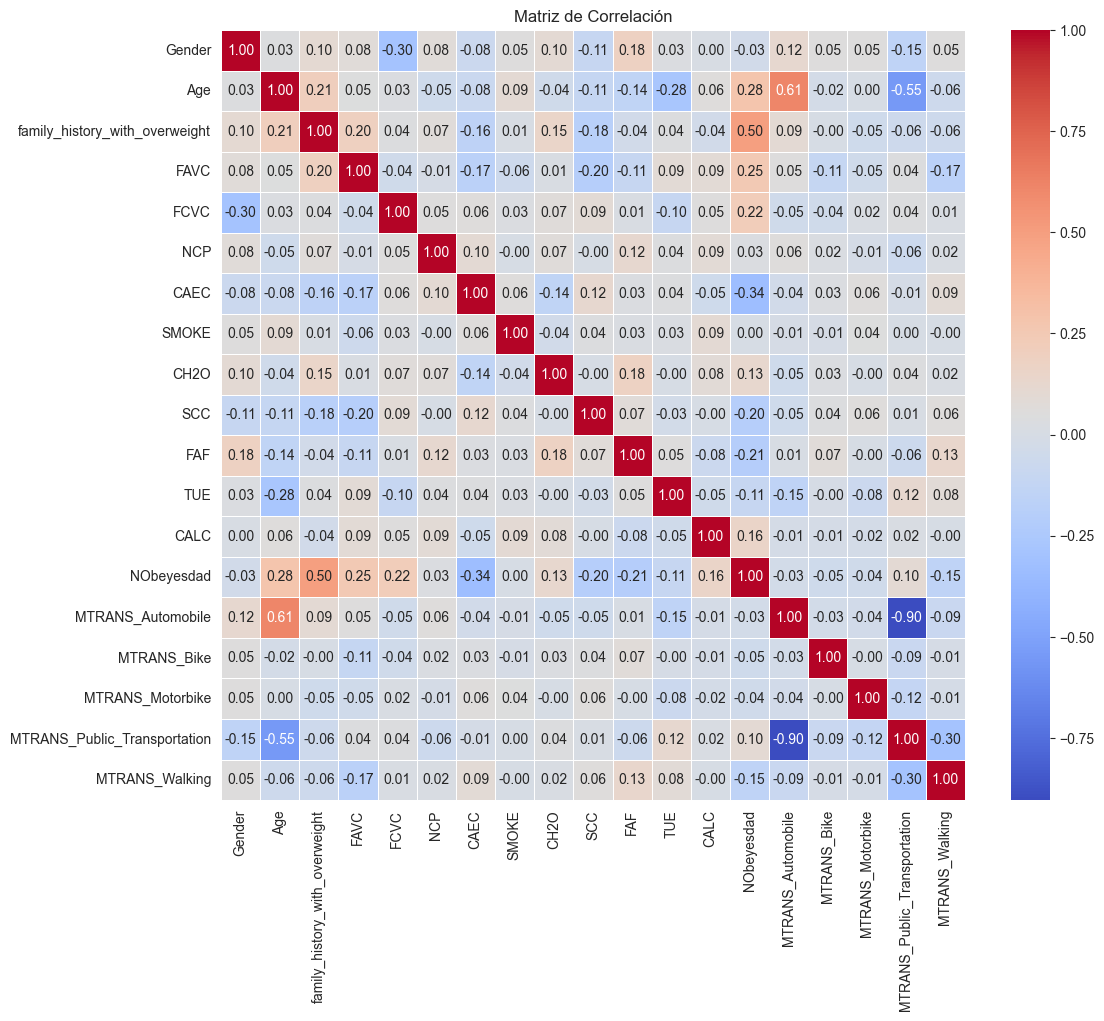

In [121]:
corr_matrix = df_new.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Matriz de Correlación')
plt.show()

(Cor)Relacions amb la variable NObeyesdad:
- Molt alta amb el pes. 
- Veiem que fumar no té correlació, podem treure la variable SMOKE. 
- L'historia de la familia té bastanta relació 
- La variable NCP té poc pes, haurem de mirar si volem eliminar-la.
- La variable transport(automobil) també té poc pes però està relacionada amb les altres de transport

Variables que estan correlaciones:
- Alçada amb el genere
- Alçada amb el pes
- PEs amb l'historial familiar
- Transport públic amb l'edat (invers)
- Automobil amb l'edat
- Transport públic amb l'automobil (invers)


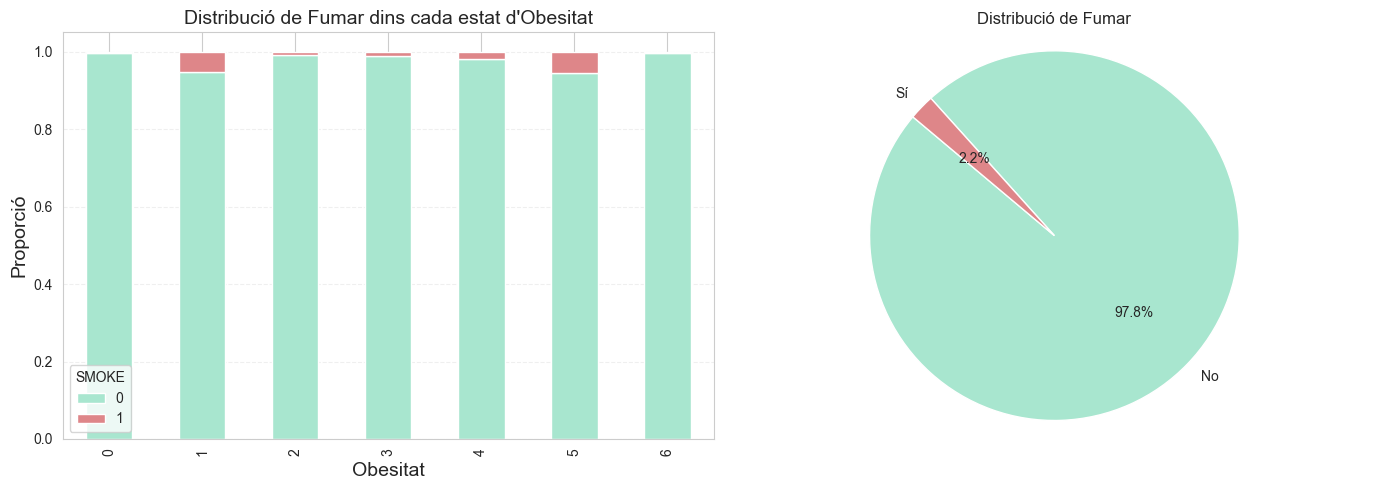

In [122]:
#Volem observar perq la variable smoke no te relacio amb l obesitat, potser que estigui desbalancejada --> per aixo és possible que no aporti info
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Gràfic 1: Distribució de fumar dins cada estat d'obesitat ---
ct_rev = pd.crosstab(df_new["NObeyesdad"], df_new['SMOKE'], normalize='index')

ct_rev.plot(kind='bar', stacked=True, color=['#A8E6CF',"#DE8689"], ax=axes[0])
axes[0].set_title('Distribució de Fumar dins cada estat d\'Obesitat', fontsize=14)
axes[0].set_xlabel('Obesitat', fontsize=14)
axes[0].set_ylabel('Proporció', fontsize=14)
axes[0].grid(alpha=0.3, axis='y', linestyle='--')

# --- Gràfic 2: Distribució global de fumadors ---
smoke_counts = df_new['SMOKE'].value_counts()

axes[1].pie(smoke_counts,
            labels=['No', 'Sí'],
            autopct='%1.1f%%',
            startangle=140,
            colors=['#A8E6CF',"#DE8689"])
axes[1].set_title('Distribució de Fumar')
axes[1].axis('equal')

plt.tight_layout()
plt.show()

Eliminem la variable SMOKE

In [123]:
df_clean = df_new[[c for c in df_new.columns if c != 'SMOKE']]


Ja hem passat les variables a numeriques, veiem que podem eliminar smoke, fem normalització i mirem si podem eliminar alguna variable més

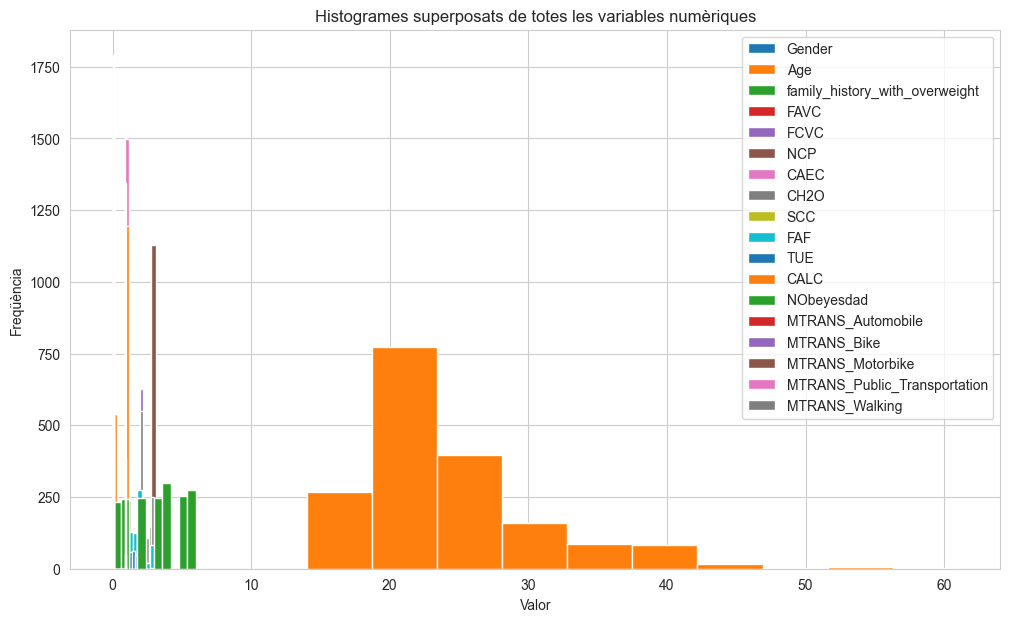

In [124]:
numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns

# Fem l'histograma superposat
plt.figure(figsize=(12, 7))

for col in numeric_cols:
    plt.hist(df_clean[col], bins=10, alpha=1, label=col)

plt.title("Histogrames superposats de totes les variables numèriques")
plt.xlabel("Valor")
plt.ylabel("Freqüència")
plt.legend(loc='upper right', fontsize=10)
plt.show()

La normalització la fem amb z-score.

Index(['Gender', 'Age', 'family_history_with_overweight', 'FAVC', 'FCVC',
       'NCP', 'CAEC', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'NObeyesdad',
       'MTRANS_Automobile', 'MTRANS_Bike', 'MTRANS_Motorbike',
       'MTRANS_Public_Transportation', 'MTRANS_Walking'],
      dtype='object')


C:\Users\annit\AppData\Local\Temp\ipykernel_46912\3965919512.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[col] = (df_clean[col] - df_clean[col].mean()) / df_clean[col].std()


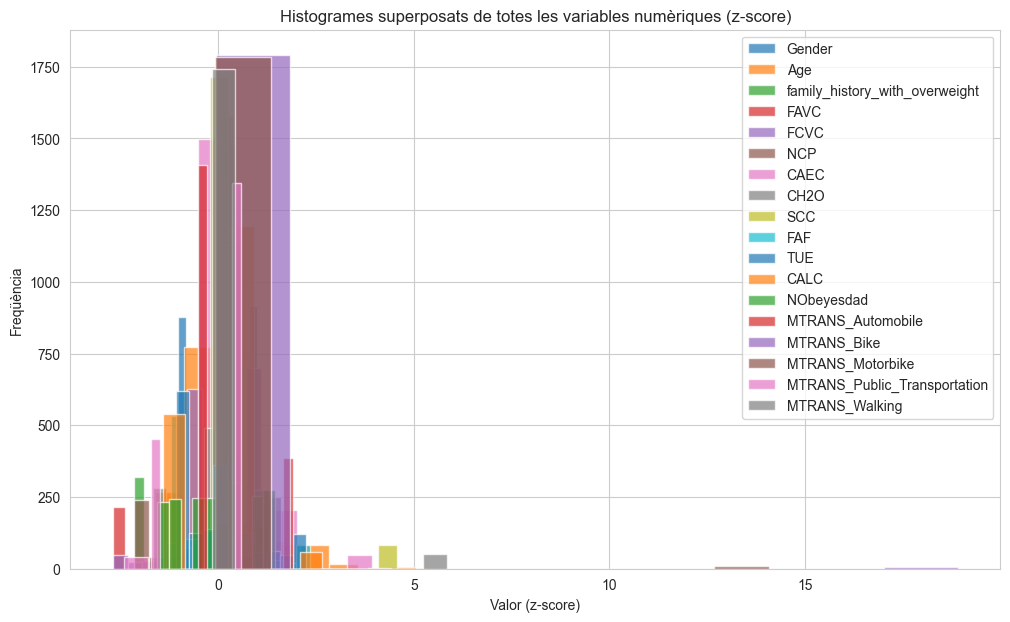

In [125]:
# Seleccionem només les columnes numèriques
numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns
print(numeric_cols)
# Transformem a z-score

for col in numeric_cols:
    df_clean[col] = (df_clean[col] - df_clean[col].mean()) / df_clean[col].std()
    
# Fem l'histograma superposat
plt.figure(figsize=(12, 7))

for col in numeric_cols:
    plt.hist(df_clean[col], bins=10, alpha=0.7, label=col)  # alpha=0.5 per veure superposició

plt.title("Histogrames superposats de totes les variables numèriques (z-score)")
plt.xlabel("Valor (z-score)")
plt.ylabel("Freqüència")
plt.legend(loc='upper right', fontsize=10)
plt.show()


In [126]:
X = df_clean[[c for c in df_clean.columns if c != 'NObeyesdad']]
y = df_clean['NObeyesdad']

#aquest test es el validation MIRAR SI S'HA DE CORREGIR
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)


Comprovem si cal eliminar alguna variable amb Lasso

In [127]:
model_lasso = Lasso(alpha=0.05)
model_lasso.fit(X, y) #no se si hauriem de posar X_train i y_train o X i y

coef = pd.Series(model_lasso.coef_, index=X.columns)
print("\nCoeficients del model LASSO:")
display(coef.sort_values(key=abs, ascending=False).to_frame("Pes de la variable"))


Coeficients del model LASSO:


,Pes de la variable
family_history_with_overweight,0.360020
Age,0.197865
CAEC,-0.197786
MTRANS_Public_Transportation,0.159227
FCVC,0.158547
FAF,-0.082370
CALC,0.074101
FAVC,0.068584
SCC,-0.038649
TUE,-0.008708


Lasso ens elimina la majoria de variables, només ens quedem amb Weight, Height, family_history_with_overweight. 

Potser Lasso no acaba de ser del tot eficient ja que tenim algunes variables altament correlacionades:
- MTRANS_Automobile - Age
- MTRANS_Public_Transportation - Age
- MTRANS_Automobile - MTRANS_Public_Transportation
- Hight - Gender


Provem de fer la selecció de variables amb Ridge

In [128]:
model_ridge = Ridge()
model_ridge.fit(X,y)

coef = pd.Series(model_ridge.coef_, index=X.columns)
print("\nCoeficients del model Ridge:")
display(coef.sort_values(key=abs, ascending=False).to_frame("Pes de la variable"))


Coeficients del model Ridge:


,Pes de la variable
family_history_with_overweight,0.373105
Age,0.290144
CAEC,-0.230525
FCVC,0.195204
MTRANS_Public_Transportation,0.134108
MTRANS_Automobile,-0.133840
FAF,-0.118366
FAVC,0.102960
CALC,0.099344
SCC,-0.073109


Provem el pes que adjudica randomforest i shap (mira les relacions no lineals també)

,Pes de la variable
family_history_with_overweight,0.250293
CAEC,0.127466
FCVC,0.126172
Age,0.124811
NCP,0.071895
FAF,0.059160
MTRANS_Public_Transportation,0.058492
TUE,0.055333
Gender,0.045606
CH2O,0.025976


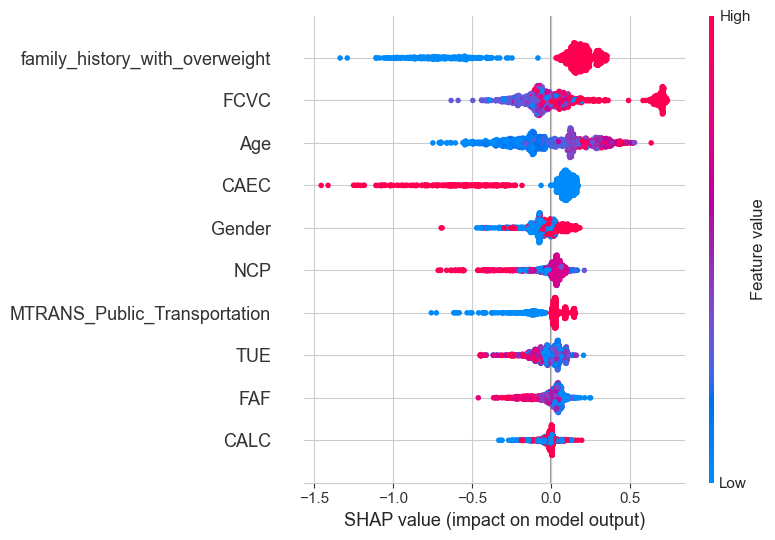

None


In [129]:
#Si vols selecció de variables fiable per prediccions, sobretot amb pocs features (21) i combinacions complexes → SHAP és millor.
#Random Forest feature importance està bé per un primer filtratge ràpid, però no és tan fiable com SHAP quan hi ha correlacions o interaccions.
rf = RandomForestRegressor(n_estimators=500, random_state=42)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns)
display(importances.sort_values(ascending=False).to_frame("Pes de la variable"))

import shap

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train)
print(shap.summary_plot(shap_values, X_train,max_display=10))

Lasso considera les variables FAVC i SCC amb més pes i Random forest, Gender i NCP.

Ens quedem amb les variables que ha predit el random forest /shap ja que té en compte també relacions no lineals.

Base de dades reduïda

In [130]:
df_reduit = df_clean[['family_history_with_overweight', 'FCVC',  'Age', 'CAEC','MTRANS_Public_Transportation', 'Gender','FAF', 'NCP', 'TUE','CALC', 'NObeyesdad']]

In [131]:
X_red = df_reduit[[c for c in df_reduit.columns if c != 'NObeyesdad']]
y_red = df_reduit['NObeyesdad']

In [132]:
#aixo es train i validation 
X_train, X_test, y_train, y_test = train_test_split(X_red, y, test_size=0.2, random_state=42) 

## Metric selection
Hem de triar una mètrica per comparar models:
- R²: compara la variància total de la variable dependent amb la variància que el model no ha pogut explicar, si el model te poca variancia, surt un r2 baix i potser molt bo i fa creure que el model no generalitza, tot i que sí ho fa.
- MAE (el que utlitzarem): Serveix per mesurar com d’equivocat està un model, de mitjana, sense exagerar els errors grans.si la MAE és baixa el model és millor.
- RMSE: mesura com s’equivoca el model però penalitzant més fortament els errors grans (eleva els errors al quadrat).
És útil si volem posar més pes als casos on la predicció falla molt. Si n'hi un de molt gran la metrica li dona molt de pes. (dubto amb aquest)

De moment utilitzem RMSE, penalitza els errors més grans

## Model selection

Algoritmes que utilitzarem:
- Regressió lineal.
- Random Forest
- Gradient boosting (XGBoost,LightGBM)
- SVR

In [133]:
lr = LinearRegression()
ypred_lr = lr.fit(X_train, y_train).predict(X_test)
mean_absolute_error(y_test, ypred_lr), np.sqrt(mean_squared_error(y_test, ypred_lr))


(0.5848063450826642, np.float64(0.7061493965652246))

In [134]:
dt = RandomForestRegressor() #el millor mae
ypred_dt= dt.fit(X_train, y_train).predict(X_test)
mean_absolute_error(y_test, ypred_dt), np.sqrt(mean_squared_error(y_test, ypred_dt))


(0.25667875205077223, np.float64(0.4134727439987248))

In [135]:
lgb = LGBMRegressor() 
ypred_lgb=lgb.fit(X_train, y_train).predict(X_test)
mean_absolute_error(y_test, ypred_lgb), np.sqrt(mean_squared_error(y_test, ypred_lgb))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1292
[LightGBM] [Info] Number of data points in the train set: 1435, number of used features: 10
[LightGBM] [Info] Start training from score 0.006961


(0.27553733371670186, np.float64(0.4060162356446901))

In [136]:
svr = SVR() 
ypred_svr=svr.fit(X_train, y_train).predict(X_test)
mean_absolute_error(y_test, ypred_svr), np.sqrt(mean_squared_error(y_test, ypred_svr))

(0.30263714129722674, np.float64(0.44799539908650793))

In [137]:
xgb = XGBRegressor() #el millor rmse
ypred_xgb=xgb.fit(X_train, y_train).predict(X_test)
mean_absolute_error(y_test, ypred_xgb), np.sqrt(mean_squared_error(y_test, ypred_xgb))

(0.2795236783379092, np.float64(0.4352400857634165))

## Validació creuada
Fem validació creuada amb els hiperparàmetres per defecte, per tenir una primera impressió. 

hauriem de mirar quants k folds fem, no cal separar les dades perq el cros validation ja ho fa en cada iteracio

In [ ]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

models = {
        "LinearRegression": LinearRegression(),
        "RandomForest": RandomForestRegressor(),
        "XGBoost": XGBRegressor(),
        "LightGBM": LGBMRegressor(),
        "SVR": SVR()
}
cv_scores = {'LinearRegression': [], 'RandomForest': [], 'XGBoost': [], 'LightGBM': [], 'SVR': []}
cv_scores_mean = {'LinearRegression': [], 'RandomForest': [], 'XGBoost': [], 'LightGBM': [], 'SVR': []}
test_scores = {'LinearRegression': [], 'RandomForest': [], 'XGBoost': [], 'LightGBM': [], 'SVR': []}
total_times = {'LinearRegression': [], 'RandomForest': [], 'XGBoost': [], 'LightGBM': [], 'SVR': []}

cv = KFold(n_splits=5,shuffle=True) 
rmse_scorer = make_scorer(rmse)

for name, model in models.items():
    start_time = time.time()
    cv_rmse_values = cross_val_score(model, X_red, y_red, cv=cv, scoring=rmse_scorer)
    end_time = time.time()
    
    cv_scores[name].extend(cv_rmse_values)            # per al boxplot
    cv_scores_mean[name].append(cv_rmse_values.mean())  # per a la taula
    total_times[name].append(end_time - start_time)


# Crear taula resum amb mitjanes
results = pd.DataFrame({
    'Model': ['LinearRegression', 'RandomForest', 'XGBoost', 'LightGBM', 'SVR'],
    'Train CV RMSE (mitjana)': [
        np.mean(cv_scores_mean['LinearRegression']),
        np.mean(cv_scores_mean['RandomForest']),
        np.mean(cv_scores_mean['XGBoost']),
        np.mean(cv_scores_mean['LightGBM']),
        np.mean(cv_scores_mean['SVR'])
    ],
    'Temps total (s)': [  # canviat el nom
        np.mean(total_times['LinearRegression']),
        np.mean(total_times['RandomForest']),
        np.mean(total_times['XGBoost']),
        np.mean(total_times['LightGBM']),
        np.mean(total_times['SVR'])
    ]
})

# Mostrar taula formatejada
styled = (
    results.style
    .set_caption("Comparació de models amb RMSE i temps total (validació creuada 5-fold)")
    .format({
        'Validació rmse (mitjana)': '{:.3f}',
        'Temps total (s)': '{:.4f}'
    })
)

styled

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1294
[LightGBM] [Info] Number of data points in the train set: 1435, number of used features: 10
[LightGBM] [Info] Start training from score -0.008841
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1291
[LightGBM] [Info] Number of data points in the train set: 1435, number of used features: 10
[LightGBM] [Info] Start training from score 0.007663
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1292
[LightGBM] [Info] Number of data points in the train set: 1435, number of used features: 10
[LightGBM] [Info] Start train

,Model,Train CV RMSE (mitjana),Temps total (s)
0,LinearRegression,0.723942,0.0640
1,RandomForest,0.380355,6.1578
2,XGBoost,0.403649,1.3799
3,LightGBM,0.394994,1.2157
4,SVR,0.436079,0.9604


C:\Users\annit\AppData\Local\Temp\ipykernel_46912\809432310.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([cv_scores[m] for m in models.keys()], labels=models.keys())


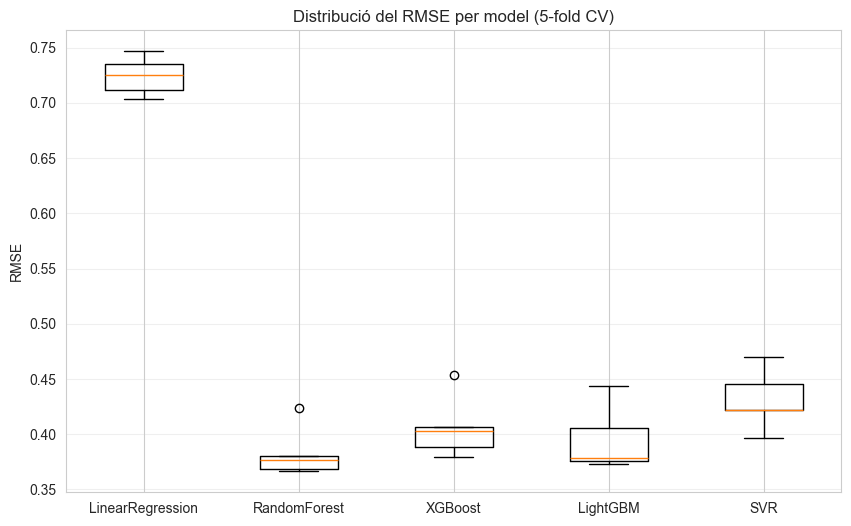

In [139]:
plt.figure(figsize=(10,6))
plt.boxplot([cv_scores[m] for m in models.keys()], labels=models.keys())
plt.ylabel("RMSE")
plt.title("Distribució del RMSE per model (5-fold CV)")
plt.grid(axis='y', alpha=0.3)
plt.show()


Volem un valor RMSE baix. De moment amb els hiperparàmetres per defecte, obtenim millors resultats amb el RandomForest, XGBoost i LightGBM. Així que farem la cerca d'hiperparametres dels models més prometedors per tal d'estalviar temps de computació.

## Cerca d'hiperparàmetres

### Regressió logística (s'ha de revisar)

In [140]:
model_reduit = LinearRegression().fit(X_train, y_train)

In [141]:
y_pred = model_reduit.predict(X_test)

In [142]:
mse = mean_squared_error(y_test, y_pred)
mse

0.4986469702694308

In [143]:
np.sqrt(mse)

np.float64(0.7061493965652246)

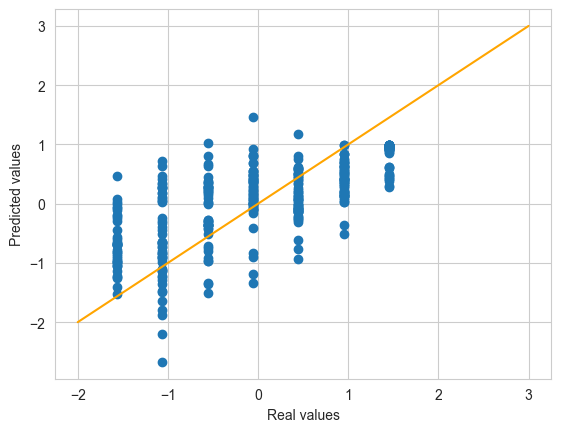

In [144]:
plt.scatter(y_test, y_pred)
plt.xlabel("Real values")
plt.ylabel("Predicted values")
plt.plot([-2, 3], [-2, 3], c="orange")
plt.show()

Aquest gràfic demostra que la nostra variable resposta no és una escala de regressió lineal contínua, sinó una sèrie de categories que hem tractat com a números. 

Fem les últimes comprovacions per veure que el nostre dataset no te bon rendiment amb regressió lineal.

In [145]:
y_pred_discret = np.round(y_pred)
y_test_discret = np.clip(y_test, a_min = 0, a_max = 6)
y_test_discret = np.round(y_test_discret)

### Coeficient de determinació (R^2)

In [146]:
r2 = r2_score(y_test_discret, y_pred_discret)
print("R-squared:", r2)

R-squared: -1.4533976833976832


Aquesta metrica mesura la proporció de variancia en la variable independent. Com més a prop de 1 sigui, millor s'adaptarà el model a les dades. Tenim un valor negatiu, és molt mal rendiment. 

### Mean square error (MSE)

In [147]:
mse = mean_squared_error(y_test_discret, y_pred_discret)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.49303621169916434


Mesura la precisió de les prediccions del model

### Mean absolut error (MAE)

In [148]:
mae = np.mean(np.abs(y_test_discret - y_pred_discret))
print("Mean Absolut Error:", mae)

Mean Absolut Error: 0.4428969359331476


### Root mean squared error (RMSE)

In [149]:
rmse_rl = np.sqrt(mean_squared_error(y_test_discret, y_pred_discret))
print("Root Mean Squared Error:", rmse_rl)

Root Mean Squared Error: 0.7021653734692166


### RandomForest

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)


param = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

cv = KFold(n_splits = 5)
rmse_scorer = make_scorer(rmse)


grid_search = GridSearchCV(RandomForestRegressor(), param, scoring = rmse_scorer, cv = cv)
grid_search.fit(X_train, y_train)

print("Millors hiperparàmetres trobats:")
print(grid_search.best_params_)
print(f"F1-score (mitjà CV): {grid_search.best_score_:.4f}")

#y_pred = grid_search.predict(X_test)
#test_f1 = f1_score(y_test, y_pred)
#print(f"F1-score sobre test: {test_f1:.4f}")



Millors hiperparàmetres trobats:
{'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 50}
F1-score (mitjà CV): 0.3979


### Boxplot de comparacio de models amb els hiperparametres triats